# TODO: 

- look at significant genes for GEP 15 and 22, make venn diagram
- look at say top 10% genes which contribute most to the GEPs. is there 

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np

from scipy.stats import pearsonr, false_discovery_control

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# target_GEP = 'GEP 15 (DNA Replication)'
target_GEP = 'GEP 22 (Cell cycle)'

In [3]:
def read_metadata():
    return pd.read_csv('./data/metadata.csv').rename(columns={'Unnamed: 0': 'cell'}).set_index('cell')

def read_full_counts():
    adata = sc.read_h5ad("./data/hultcd34_full.h5ad")
    adata.obs = metadata
    df = adata.to_df()
    return df.merge(metadata, left_index=True, right_index=True)

# account for cells thrown out in cell-GEP dataframe, also keep only HSCs and progenitors
def filter_full_counts(df):
    cell_GEP_mapping = read_cell_GEP()
    gep_set = set(cell_GEP_mapping.index)
    raw_counts_set = set(df.index)
    difference = raw_counts_set.difference(gep_set)
    
    df = df[~df.index.isin(difference)]
    df = (df
          [(df['cluster'] != 'Uncommitted') | (df['subcluster'] == 'HSC')]
          .iloc[:, :-9]
         )
    
    return df

def read_cell_GEP():
    cell_GEP_mapping = pd.read_csv(r'./data/Factorized matrices from human lifetime scRNA(GEP usage per cell).csv').set_index('Cell')
    return cell_GEP_mapping.merge(metadata, left_index=True, right_index=True)
    
# keep only HSCs and progenitors
def filter_cell_GEP(cell_GEP_mapping):
    cell_GEP_mapping = (cell_GEP_mapping
                    [(cell_GEP_mapping['cluster'] != 'Uncommitted') | (cell_GEP_mapping['subcluster'] == 'HSC')]
                    .iloc[:, :35]
                   )
    return cell_GEP_mapping

In [4]:
def get_merged(df, cell_GEP_mapping):
    target = cell_GEP_mapping[[target_GEP]]
    df = (df
          .merge(target, left_index=True, right_index=True)
          .merge(metadata, left_index=True, right_index=True)
          )
    return df

def get_HSC(merged):
    hsc = merged[merged['subcluster'] == 'HSC'].iloc[:, :-9]
    hsc_X = hsc.iloc[:, :-1]
    hsc_y = hsc[target_GEP]
    return hsc_X, hsc_y

def get_prog(merged):
    prog = merged[merged['cluster'] != 'Uncommitted'].iloc[:, :-9]
    prog_X = prog.iloc[:, :-1]
    prog_y = prog[target_GEP]
    return prog_X, prog_y

In [5]:
def get_stats_hsc(col):
    X = col
    y = hsc_y
    r, p_val = pearsonr(X, y)
    hsc_res.append({'gene': col.name, 'r hsc': r, 'p hsc': p_val})

def get_stats_prog(col):
    X = col
    y = prog_y
    r, p_val = pearsonr(X, y)
    prog_res.append({'gene': col.name, 'r prog': r, 'p prog': p_val})

In [6]:
# metadata = read_metadata()
# df = (read_full_counts()
#       .pipe(filter_full_counts)
#      )
# cell_GEP_mapping = (read_cell_GEP()
#                     .pipe(filter_cell_GEP)
#                    )

In [7]:
# merged = get_merged(df, cell_GEP_mapping)
# hsc_X, hsc_y = get_HSC(merged)
# prog_X, prog_y = get_prog(merged)

In [8]:
# hsc_res = []
# hsc_X.apply(get_stats_hsc)
# hsc_df = pd.DataFrame(hsc_res).set_index('gene')

# prog_res = []
# prog_X.apply(get_stats_prog)
# prog_df = pd.DataFrame(prog_res).set_index('gene')

# res = hsc_df.merge(prog_df, left_index=True, right_index=True)

In [9]:
# res.to_csv(f'correlations/GEP_{target_GEP[4:6]}_results.csv', index=True)
res = pd.read_csv(f'correlations/GEP_{target_GEP[4:6]}_results.csv').set_index('gene')

In [10]:
# some nans exist in correlations, how to deal?
alpha = 0.05

filtered = res.dropna()
filtered['p adjusted hsc'] = false_discovery_control(filtered['p hsc'])
filtered['p adjusted prog'] = false_discovery_control(filtered['p prog'])
filtered['hsc significant'] = filtered['p adjusted hsc'] < alpha
filtered['prog significant'] = filtered['p adjusted prog'] < alpha
filtered = filtered[['r hsc', 'p hsc', 'p adjusted hsc', 'hsc significant', 'r prog', 'p prog', 'p adjusted prog', 'prog significant']]

/scratch/sbhayani/job_38729084/ipykernel_3293757/2224245022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['p adjusted hsc'] = false_discovery_control(filtered['p hsc'])
/scratch/sbhayani/job_38729084/ipykernel_3293757/2224245022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['p adjusted prog'] = false_discovery_control(filtered['p prog'])
/scratch/sbhayani/job_38729084/ipykernel_3293757/2224245022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [11]:
filtered.head()

,r hsc,p hsc,p adjusted hsc,hsc significant,r prog,p prog,p adjusted prog,prog significant
gene,,,,,,,,
X5S-rRNA,-0.008762,0.404908,0.976035,False,-0.011599,0.037631,0.117145,False
X5-8S-rRNA,0.003454,0.742684,0.985258,False,-0.000943,0.865788,0.935840,False
X7SK,-0.020487,0.051457,0.730529,False,-0.005388,0.334185,0.557009,False
A1BG,-0.005858,0.577631,0.976035,False,-0.006603,0.236667,0.448448,False
A1BG.AS1,-0.006093,0.562483,0.976035,False,0.003554,0.524167,0.722288,False


In [26]:
filtered[(filtered['r hsc'] < 0) & (filtered['r prog'] > 0) & (filtered['hsc significant'] == True) & (filtered['prog significant'] == True)].head(20)

,r hsc,p hsc,p adjusted hsc,hsc significant,r prog,p prog,p adjusted prog,prog significant
gene,,,,,,,,
ACTB,-0.039236,1.906779e-04,2.558688e-02,True,0.190182,2.550664e-259,5.824612e-257,True
ACTG1,-0.045951,1.241156e-05,2.498242e-03,True,0.130761,1.718967e-122,1.641172e-120,True
ADSL,-0.041200,8.930524e-05,1.354252e-02,True,0.064499,5.720021e-31,1.193168e-29,True
BTF3,-0.045554,1.475137e-05,2.923992e-03,True,0.021696,1.007222e-04,5.704281e-04,True
C4orf3,-0.038831,2.221122e-04,2.843691e-02,True,0.053279,1.228106e-21,1.864554e-20,True
C6orf48,-0.038857,2.199093e-04,2.825847e-02,True,0.027184,1.099787e-06,7.681201e-06,True
CALU,-0.037305,3.893038e-04,4.368369e-02,True,0.022096,7.474842e-05,4.302552e-04,True
CCDC142,-0.038380,2.626760e-04,3.235720e-02,True,0.039758,1.015787e-12,1.051576e-11,True
CCDC85B,-0.037138,4.134515e-04,4.586610e-02,True,0.016582,2.957868e-03,1.320019e-02,True


In [24]:
filtered[(filtered['hsc significant'] == True) & (filtered['prog significant'] == True)].head(20)

,r hsc,p hsc,p adjusted hsc,hsc significant,r prog,p prog,p adjusted prog,prog significant
gene,,,,,,,,
AC006019.3,0.076542,3.182130e-13,4.437821e-10,True,0.015166,6.562738e-03,2.694864e-02,True
ACSM5,0.038338,2.668340e-04,3.256126e-02,True,0.057280,9.197356e-25,1.572450e-23,True
ACTB,-0.039236,1.906779e-04,2.558688e-02,True,0.190182,2.550664e-259,5.824612e-257,True
ACTG1,-0.045951,1.241156e-05,2.498242e-03,True,0.130761,1.718967e-122,1.641172e-120,True
ADSL,-0.041200,8.930524e-05,1.354252e-02,True,0.064499,5.720021e-31,1.193168e-29,True
AHNAK2,0.040231,1.304055e-04,1.872134e-02,True,0.178601,1.879681e-228,3.633646e-226,True
ANP32E,0.110823,4.245707e-26,1.507187e-22,True,0.314854,0.000000e+00,0.000000e+00,True
AP000282.3,0.049335,2.699967e-06,6.936250e-04,True,0.019377,5.142491e-04,2.644661e-03,True
APOLD1,0.069544,3.627656e-11,3.541408e-08,True,0.166085,2.077636e-197,3.352463e-195,True


In [18]:
(filtered
 .sort_values(by='r hsc', ascending=False)
 .head(25)
)

,r hsc,p hsc,p adjusted hsc,hsc significant,r prog,p prog,p adjusted prog,prog significant
gene,,,,,,,,
ASPM,0.227699,1.267599e-106,4.949846e-102,True,0.476178,0.000000e+00,0.000000e+00,True
CENPF,0.219701,3.228699e-99,6.303872e-95,True,0.562577,0.000000e+00,0.000000e+00,True
CENPA,0.200545,1.190991e-82,1.550233e-78,True,0.453325,0.000000e+00,0.000000e+00,True
CCNB2,0.184714,3.471297e-70,3.388767e-66,True,0.516588,0.000000e+00,0.000000e+00,True
ARL6IP1,0.180175,8.180936e-67,6.389148e-63,True,0.508993,0.000000e+00,0.000000e+00,True
RP11.483A20.3,0.137993,1.143613e-39,7.442827e-36,True,-0.009653,8.360005e-02,2.173724e-01,False
RAD21,0.132444,1.188327e-36,6.628997e-33,True,0.374989,0.000000e+00,0.000000e+00,True
TOP2A,0.128756,1.023471e-34,4.995691e-31,True,0.649274,0.000000e+00,0.000000e+00,True
HMGB2,0.116728,8.597803e-29,3.730396e-25,True,0.593789,0.000000e+00,0.000000e+00,True


In [12]:
def plot_cdf(df, col_name):
    s = df[col_name]
    cdf = s.rank(method='average', pct=True)
    sorted_s = s.sort_values()
    sorted_cdf = cdf[sorted_s.index]
    
    # Get corresponding significance values
    sig = 'hsc significant' if 'hsc' in col_name else 'prog significant'
    significance = df.loc[sorted_s.index, sig]
    
    # Create the scatter plot with two colors
    plt.figure(figsize=(8, 6))
    for label, color in zip([True, False], ['blue', 'gray']):
        mask = significance == label
        plt.scatter(
            sorted_s[mask].values,
            sorted_cdf[mask].values,
            c=color,
            label='Significant' if label else 'Not Significant',
            alpha=0.4,
        )

    cell_type = 'HSCs' if 'hsc' in col_name else 'Progenitors'
    plt.xlabel(col_name)
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title(f'gene vs. GEP {target_GEP[4:6]} correlations for {cell_type} only')
    plt.show()

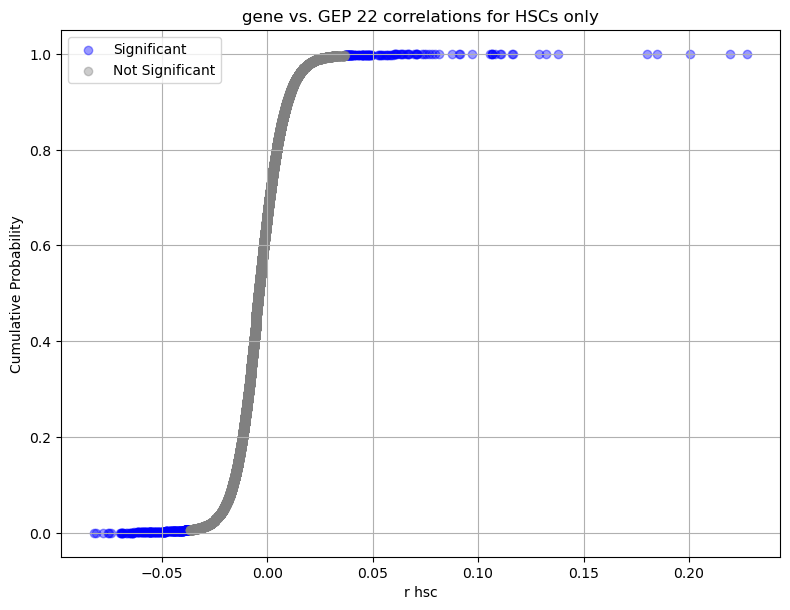

In [27]:
plot_cdf(filtered, 'r hsc')